# CHAPTER 11 - The Best of Both Worlds: Hybrid Architectures - PennyLane Code

*Note*: You may skip the following five cells if you have alredy installed the right versions of all the libraries mentioned in *Appendix D*. This will likely NOT be the case if you are running this notebook on a cloud service such as Google Colab.

In [ ]:
pip install scikit-learn==1.2.1

In [ ]:
pip install tensorflow==2.9.1

In [ ]:
pip install pennylane==0.26

In [ ]:
pip install matplotlib==3.2.2

In [ ]:
pip install optuna==3.0.3

In [1]:
import numpy as np
import tensorflow as tf

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.datasets import make_classification

In [4]:
tf.keras.backend.set_floatx('float64')

In [5]:
import pennylane as qml

state_0 = [[1], [0]]
M = state_0 * np.conj(state_0).T

In [6]:
import matplotlib.pyplot as plt

def plot_losses(history):
    tr_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = np.array(range(len(tr_loss))) + 1
    plt.plot(epochs, tr_loss, label = "Training loss")
    plt.plot(epochs, val_loss, label = "Validation loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [7]:
x, y = make_classification(n_samples = 1000, n_features = 20)

In [8]:
x_tr, x_test, y_tr, y_test = train_test_split(
    x, y, train_size = 0.8)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, train_size = 0.5)

In [15]:
def TwoLocal(nqubits, theta, reps = 1):
    
    for r in range(reps):
        for i in range(nqubits):
            qml.RY(theta[r * nqubits + i], wires = i)
        for i in range(nqubits - 1):
            qml.CNOT(wires = [i, i + 1])
    
    for i in range(nqubits):
        qml.RY(theta[reps * nqubits + i], wires = i)

In [14]:
nqubits = 4
dev = qml.device("lightning.qubit", wires = nqubits)

@qml.qnode(dev, interface="tf", diff_method = "adjoint")
def qnn(inputs, theta):
    qml.AngleEmbedding(inputs, range(nqubits))
    TwoLocal(nqubits, theta, reps = 2)
    return qml.expval(qml.Hermitian(M, wires = [0]))

weights = {"theta": 12}

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(20),
    tf.keras.layers.Dense(4, activation = "sigmoid"),
    qml.qnn.KerasLayer(qnn, weights, output_dim=1)
])

In [12]:
qlayer = qml.qnn.KerasLayer(qnn, weights, output_dim=1)
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(20),
    tf.keras.layers.Dense(4, activation = "sigmoid"),
    qlayer
])

In [17]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, verbose=1,
    restore_best_weights=True)

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.005)
model.compile(opt, loss=tf.keras.losses.BinaryCrossentropy())

history = model.fit(x_tr, y_tr, epochs = 50, shuffle = True,
    validation_data = (x_val, y_val),
    batch_size = 10,
    callbacks = [earlystop])

Epoch 1/50
80/80 [==============================] - 4s 55ms/step - loss: 0.8672 - val_loss: 0.7325
Epoch 2/50
80/80 [==============================] - 4s 55ms/step - loss: 0.6798 - val_loss: 0.6465
Epoch 3/50
80/80 [==============================] - 4s 55ms/step - loss: 0.6307 - val_loss: 0.6034
Epoch 4/50
80/80 [==============================] - 5s 57ms/step - loss: 0.5887 - val_loss: 0.5607
Epoch 5/50
80/80 [==============================] - 4s 55ms/step - loss: 0.5502 - val_loss: 0.5275
Epoch 6/50
80/80 [==============================] - 4s 55ms/step - loss: 0.5189 - val_loss: 0.5013
Epoch 7/50
80/80 [==============================] - 5s 58ms/step - loss: 0.4894 - val_loss: 0.4795
Epoch 8/50
80/80 [==============================] - 4s 56ms/step - loss: 0.4642 - val_loss: 0.4612
Epoch 9/50
80/80 [==============================] - 4s 55ms/step - loss: 0.4462 - val_loss: 0.4497
Epoch 10/50
80/80 [==============================] - 5s 56ms/step - loss: 0.4334 - val_loss: 0.4418
Epoch 11/

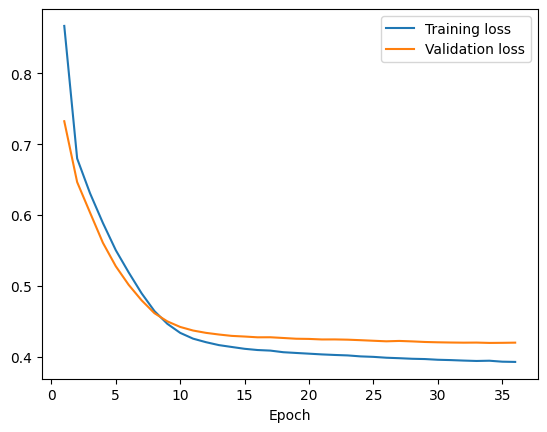

In [15]:
plot_losses(history)

In [16]:
tr_acc = accuracy_score(model.predict(x_tr) >= 0.5, y_tr)
val_acc = accuracy_score(model.predict(x_val) >= 0.5, y_val)
test_acc = accuracy_score(model.predict(x_test) >= 0.5, y_test)
print("Train accuracy:", tr_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)

4/4 [==============================] - 0s 34ms/step
Train accuracy: 0.94625
Validation accuracy: 0.91
Test accuracy: 0.96


In [19]:
#!pip3 install optuna

In [10]:
import optuna

In [11]:
def objective(trial):
    # Define the learning rate as an optimizable parameter.
    lrate = trial.suggest_float("learning_rate", 0.001, 0.1)

    # Define the optimizer with the learning rate.
    opt = tf.keras.optimizers.Adam(learning_rate = lrate)

    # Prepare and compile the model.
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(20),
        tf.keras.layers.Dense(4, activation = "sigmoid"),
        qml.qnn.KerasLayer(qnn, weights, output_dim=1)
    ])
    model.compile(opt, loss=tf.keras.losses.BinaryCrossentropy())

    # Train it!
    history = model.fit(x_tr, y_tr, epochs = 50, shuffle = True,
        validation_data = (x_val, y_val),
        batch_size = 10,
        callbacks = [earlystop],
        verbose = 0 # We want TensorFlow to be quiet.
    )
    
    # Return the validation accuracy.
    return accuracy_score(model.predict(x_val) >= 0.5, y_val)

In [12]:
from optuna.samplers import TPESampler

study = optuna.create_study(direction='maximize',
    sampler=TPESampler(seed = seed))

[I 2024-03-12 21:25:13,191] A new study created in memory with name: no-name-d57a2d68-dad9-4ad8-928f-c380080af0a0


In [18]:
study.optimize(objective, n_trials=6)

Restoring model weights from the end of the best epoch: 8.
Epoch 10: early stopping
4/4 [==============================] - 0s 35ms/step


[I 2024-03-12 21:26:36,960] Trial 2 finished with value: 0.9 and parameters: {'learning_rate': 0.04433504616170433}. Best is trial 2 with value: 0.9.


Restoring model weights from the end of the best epoch: 4.
Epoch 6: early stopping
4/4 [==============================] - 0s 37ms/step


[I 2024-03-12 21:27:02,331] Trial 3 finished with value: 0.91 and parameters: {'learning_rate': 0.07875049978766316}. Best is trial 3 with value: 0.91.


Restoring model weights from the end of the best epoch: 6.
Epoch 8: early stopping
4/4 [==============================] - 0s 34ms/step


[I 2024-03-12 21:27:35,587] Trial 4 finished with value: 0.91 and parameters: {'learning_rate': 0.07821760500376156}. Best is trial 3 with value: 0.91.


Restoring model weights from the end of the best epoch: 8.
Epoch 10: early stopping
4/4 [==============================] - 0s 35ms/step


[I 2024-03-12 21:28:16,343] Trial 5 finished with value: 0.9 and parameters: {'learning_rate': 0.02798666792298152}. Best is trial 3 with value: 0.91.


Restoring model weights from the end of the best epoch: 4.
Epoch 6: early stopping
4/4 [==============================] - 0s 35ms/step


[I 2024-03-12 21:28:41,137] Trial 6 finished with value: 0.89 and parameters: {'learning_rate': 0.028369961259166576}. Best is trial 3 with value: 0.91.


Restoring model weights from the end of the best epoch: 11.
Epoch 13: early stopping
4/4 [==============================] - 0s 34ms/step


[I 2024-03-12 21:29:34,523] Trial 7 finished with value: 0.91 and parameters: {'learning_rate': 0.08038534557596691}. Best is trial 3 with value: 0.91.


In [25]:
np.random.seed(seed)
tf.random.set_seed(seed)

In [26]:
x, y = make_classification(n_samples = 1000, n_features = 20,
    n_classes = 3, n_clusters_per_class = 1)

In [27]:
from sklearn.preprocessing import OneHotEncoder
hot = OneHotEncoder()
y_hot = hot.fit_transform(y.reshape(-1,1))

In [28]:
x_tr, x_test, y_tr, y_test = train_test_split(
    x, y_hot, train_size = 0.8)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, train_size = 0.5)

In [29]:
nqubits = 4
dev = qml.device("lightning.qubit", wires = nqubits)

@qml.qnode(dev, interface="tf", diff_method = "adjoint")
def qnn(inputs, theta):
    qml.AngleEmbedding(inputs, range(nqubits))
    TwoLocal(nqubits, theta, reps = 2)
    return [qml.expval(qml.Hermitian(M, wires = [0])),
            qml.expval(qml.Hermitian(M, wires = [1])),
            qml.expval(qml.Hermitian(M, wires = [2]))]

weights = {"theta": 12}

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(20),
    tf.keras.layers.Dense(8, activation = "elu"),
    tf.keras.layers.Dense(4, activation = "sigmoid"),
    qml.qnn.KerasLayer(qnn, weights, output_dim = 3),
    tf.keras.layers.Activation(activation = "softmax")
])

In [33]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(opt, loss=tf.keras.losses.CategoricalCrossentropy())

#y_test = tf.cast(y_tr[1:], tf.int32)
#y_valid = tf.cast(y_val[1:], tf.int32)

history = model.fit(x_tr, y_tr, epochs = 50, shuffle = True,
    validation_data = (x_val, y_val),
    batch_size = 10,
    callbacks = [earlystop])

Epoch 1/50


ValueError: Attempt to convert a value (SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 2]
 [2 1]
 [3 1]
 [4 2]
 [5 2]
 [6 2]
 [7 0]
 [8 0]
 [9 0]], shape=(10, 2), dtype=int64), values=tf.Tensor([1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], shape=(10,), dtype=float64), dense_shape=tf.Tensor([10  3], shape=(2,), dtype=int64))) with an unsupported type (<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>) to a Tensor.

In [ ]:
plot_losses(history)

In [ ]:
tr_acc = accuracy_score(
    model.predict(x_tr).argmax(axis = 1),
    y_tr.argmax(axis = 1))
val_acc = accuracy_score(
    model.predict(x_val).argmax(axis = 1),
    y_val.argmax(axis = 1))
test_acc = accuracy_score(
    model.predict(x_test).argmax(axis = 1),
    y_test.argmax(axis = 1))
print("Train accuracy:", tr_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)

In [46]:
!pip install tensorflow==2.15

  Obtaining dependency information for tensorflow==2.15 from https://files.pythonhosted.org/packages/b8/95/0fb1c154bb02f7f7b44138219926519ac19339493b32ff6eefa9bbc83769/tensorflow-2.15.0-cp39-cp39-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for tensorflow-macos==2.15.0 from https://files.pythonhosted.org/packages/3e/ca/4d8aede401f69ebe6dfdb8ef0681bb30ae6051b6441cb25a047e334f9a86/tensorflow_macos-2.15.0-cp39-cp39-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for tensorboard<2.16,>=2.15 from https://files.pythonhosted.org/packages/37/12/f6e9b9dcc310263cbd3948274e286538bd6800fd0c268850788f14a0c6d0/tensorboard-2.15.2-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow-estimator<2.16,>=2.15.0 from https://files.pythonhosted.org/packages/b6/c8/2f823c8958d5342eafc6dd3e922f0cc4fcf8c2e0460284cc462dae3b60a0/tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for keras<2.16,>=2.15.0 from http